## Khai báo thư viện

In [1]:
import cv2
import numpy as np
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import traceback
from skimage.feature import hog, local_binary_pattern

## Chuẩn hoá đường dẫn lưu trữ file

In [2]:
# Đường dẫn thư mục cha
PROJECT_DIR = Path.cwd().parent

# Đường dẫn đến thư mục dữ liệu
DATA_DIR = PROJECT_DIR / "data"
INTERIM_DIR = DATA_DIR / "02_interim"
PROCESSED_DIR = DATA_DIR / "03_processed"

# Tạo thư mục đầu ra nếu chưa tồn tại
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

print(f"Project Dir:     {PROJECT_DIR}")
print(f"Interim Dir (In):  {INTERIM_DIR}")
print(f"Processed Dir (Out): {PROCESSED_DIR}")


Project Dir:     /Users/CONG HAU/UIT-CS-PROJECTS/CS231 - Introduction to Computer Vision
Interim Dir (In):  /Users/CONG HAU/UIT-CS-PROJECTS/CS231 - Introduction to Computer Vision/data/02_interim
Processed Dir (Out): /Users/CONG HAU/UIT-CS-PROJECTS/CS231 - Introduction to Computer Vision/data/03_processed


## Chuẩn bị data

Đang tải: train_data.npz...
Đã tải thành công train_data.npz. X: (8226, 224, 224, 3), y: (8226,)
Đang tải: val_data.npz...
Đã tải thành công val_data.npz. X: (2742, 224, 224, 3), y: (2742,)
Đang tải: test_data.npz...
Đã tải thành công test_data.npz. X: (2743, 224, 224, 3), y: (2743,)

Hiển thị ảnh mẫu từ tập TRAIN:


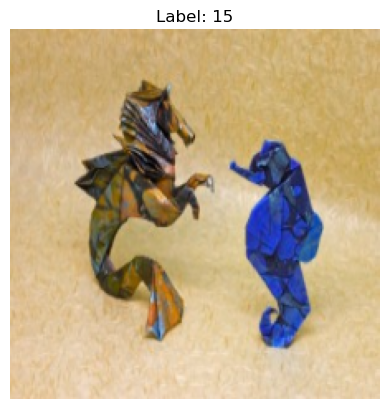

In [3]:
def load_data_split(data_dir, filename):
    data_path = data_dir / filename

    if not data_path.exists():
        print(f"Không tìm thấy file tại '{data_path}'.")
        print("Sẽ trả về (None, None).")
        return None, None

    try:
        print(f"Đang tải: {filename}...")
        data = np.load(data_path)
        X = data['X']
        y = data['y']
        print(f"Đã tải thành công {filename}. X: {X.shape}, y: {y.shape}")
        return X, y
    except Exception as e:
        print(f"Lỗi khi tải '{data_path}': {e}")
        return None, None

# Tải cả 3 tập dữ liệu
X_train, y_train = load_data_split(INTERIM_DIR, 'train_data.npz')
X_val,   y_val   = load_data_split(INTERIM_DIR, 'val_data.npz')
X_test,  y_test  = load_data_split(INTERIM_DIR, 'test_data.npz')

# Hiển thị ảnh mẫu (từ tập train)
if X_train is not None and X_train.shape[0] > 0:
    print("\nHiển thị ảnh mẫu từ tập TRAIN:")
    sample_image = X_train[0]

    if sample_image.ndim == 3 and sample_image.shape[2] == 3:
        plt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
    elif sample_image.ndim == 2:
        plt.imshow(sample_image, cmap='gray')
    else:
        plt.imshow(sample_image)

    plt.title(f"Label: {y_train[0]}")
    plt.axis('off')
    plt.show()
else:
    print("Không có dữ liệu tập train để hiển thị.")

## Trích xuất đặc trưng

### Color Histogram

In [4]:
def extract_color_histogram(image, bins=(8, 8, 8)):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv_image], [0, 1, 2], None, bins,
                        [0, 180, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

### Sharpen Detection

In [5]:
def extract_sharpen_features(image, hist_bins=256):
    # Chuyển sang ảnh xám
    if image.ndim == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    # Định nghĩa kernel "sharpen"
    kernel = np.array([[ 0, -1,  0],
                       [-1,  5, -1],
                       [ 0, -1,  0]])

    # Áp dụng bộ lọc
    sharpened_img = cv2.filter2D(gray, -1, kernel)

    # Tính histogram của ảnh đã làm nét
    hist = cv2.calcHist([sharpened_img], [0], None, [hist_bins], [0, 256])

    # Normalize histogram
    cv2.normalize(hist, hist)

    # Flatten
    return hist.flatten()

### HOG

In [6]:
def extract_hog_features(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), orientations=9):
    # Chuyển sang ảnh xám nếu là ảnh màu
    if image.ndim == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image

    # Trích xuất đặc trưng HOG
    features = hog(gray_image, orientations=orientations,
                   pixels_per_cell=pixels_per_cell,
                   cells_per_block=cells_per_block,
                   visualize=False,
                   block_norm='L2-Hys')

    return features

### LBP

In [7]:
def extract_lbp_features(image, P=24, R=8, eps=1e-7):
    # Chuyển sang ảnh xám nếu là ảnh màu
    if image.ndim == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image

    # Tính LBP
    lbp = local_binary_pattern(gray_image, P, R, method="uniform")

    # Tính histogram của LBP
    (hist, _) = np.histogram(lbp.ravel(),
                             bins=np.arange(0, P + 3),
                             range=(0, P + 2))

    # Normalize histogram
    hist = hist.astype("float")
    hist /= (hist.sum() + eps)

    return hist

### Thực hiện trích xuất

In [8]:
def apply_feature_extraction(X_data, feature_extractor_func, desc="", return_processed_image=False):
    if X_data is None:
        print(f"Bỏ qua {desc} vì không có dữ liệu.")
        return None, None if return_processed_image else None

    features = []
    processed_images = [] if return_processed_image else None

    for img in tqdm(X_data, desc=f"Extracting {desc}"):
        # Chuẩn hóa ảnh về uint8 nếu cần
        if img.dtype != np.uint8:
            img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

        # Đảm bảo ảnh là 3 channel nếu cần
        if img.ndim == 2:
            img_bgr = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        else:
            img_bgr = img

        feats = feature_extractor_func(img_bgr)
        features.append(feats)

        if return_processed_image:
            # Depending on the feature extractor, the 'processed' image might vary.
            # For now, let's return the grayscale image for HOG and LBP,
            # the sharpened image for Sharpen, and the HSV image for Color Histogram.
            if 'HOG' in desc or 'LBP' in desc:
                 processed_images.append(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY))
            elif 'Sharpen' in desc:
                # Need to re-apply sharpen to get the sharpened image
                gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
                kernel = np.array([[ 0, -1,  0],
                                   [-1,  5, -1],
                                   [ 0, -1,  0]])
                processed_images.append(cv2.filter2D(gray, -1, kernel))
            elif 'Color Histogram' in desc:
                processed_images.append(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV))
            else:
                 processed_images.append(img_bgr)


    features_array = np.array(features)

    if return_processed_image:
        return features_array, np.array(processed_images)
    else:
        return features_array

#### 1. Trích xuất Color Histogram

In [ ]:
# Trích xuất cho cả 3 tập
X_train_hist = apply_feature_extraction(X_train, extract_color_histogram, "Color Histogram (Train)")
X_val_hist   = apply_feature_extraction(X_val, extract_color_histogram, "Color Histogram (Val)")
X_test_hist  = apply_feature_extraction(X_test, extract_color_histogram, "Color Histogram (Test)")

# In thông tin
if X_train_hist is not None:
    print(f"\nShape của đặc trưng Color Histogram (Train): {X_train_hist.shape}")
    # print(f"Mẫu đặc trưng đầu tiên:\n{X_train_hist[0][:10]}...") # In 10 giá trị đầu

Extracting Color Histogram (Train):   0%|          | 0/8226 [00:00<?, ?it/s]

Extracting Color Histogram (Val):   0%|          | 0/2742 [00:00<?, ?it/s]

Extracting Color Histogram (Test):   0%|          | 0/2743 [00:00<?, ?it/s]


Shape của đặc trưng Color Histogram (Train): (8226, 512)
Mẫu đặc trưng đầu tiên:
[0.00014827 0.00103791 0.001631   0.00098848 0.00088963 0.00217466
 0.00158157 0.00024712 0.00039539 0.00350912]...


#### 2. Trích xuất Sharpen Features

In [ ]:
# Trích xuất cho cả 3 tập
X_train_sharp = apply_feature_extraction(X_train, extract_sharpen_features, "Sharpen (Train)")
X_val_sharp   = apply_feature_extraction(X_val, extract_sharpen_features, "Sharpen (Val)")
X_test_sharp  = apply_feature_extraction(X_test, extract_sharpen_features, "Sharpen (Test)")

# In thông tin
if X_train_sharp is not None:
    print(f"\nShape của đặc trưng Sharpen (Train): {X_train_sharp.shape}")
    # print(f"Mẫu đặc trưng đầu tiên:\n{X_train_sharp[0][:10]}...")

Extracting Sharpen (Train):   0%|          | 0/8226 [00:00<?, ?it/s]

Extracting Sharpen (Val):   0%|          | 0/2742 [00:00<?, ?it/s]

Extracting Sharpen (Test):   0%|          | 0/2743 [00:00<?, ?it/s]


Shape của đặc trưng Sharpen (Train): (8226, 256)
Mẫu đặc trưng đầu tiên:
[0.14814    0.00554535 0.0053473  0.00594144 0.00415901 0.00712973
 0.0057434  0.00435706 0.00514925 0.00613949]...


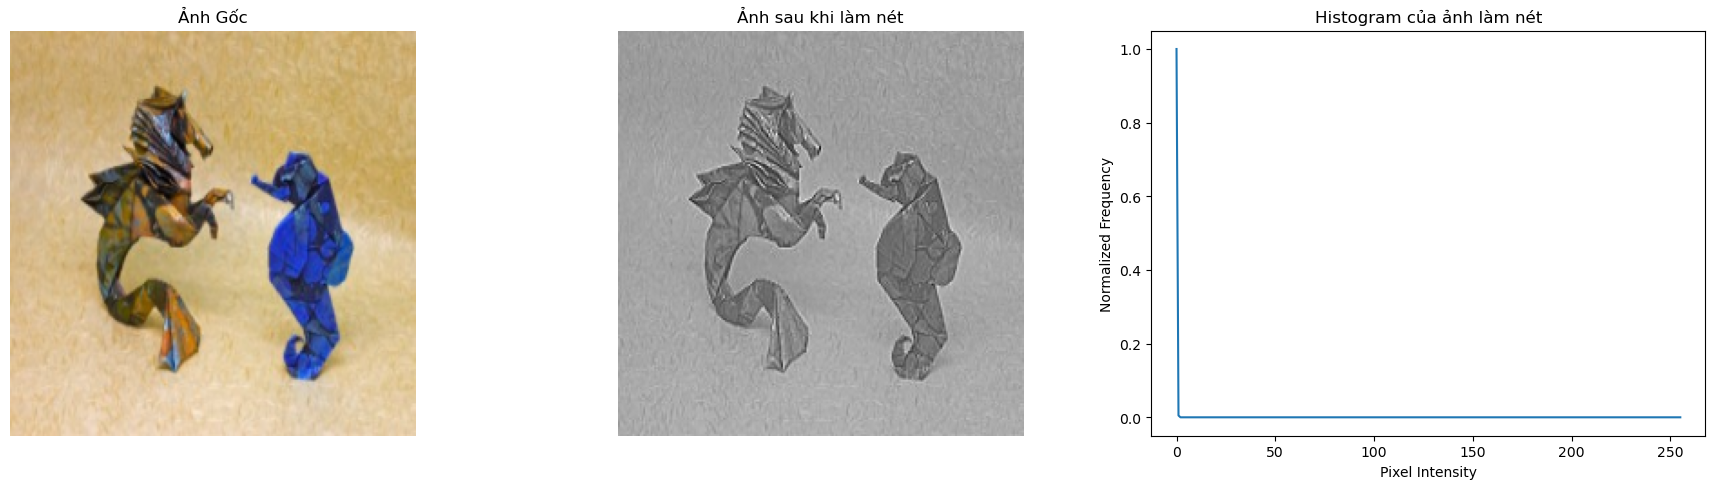

In [16]:
if 'sample_image' in locals():
    # Lấy vector đặc trưng
    hist_sharp_features = extract_sharpen_features(sample_image)
    
    # Để trực quan, ta cần tạo lại ảnh đã làm nét
    gray_sample = cv2.cvtColor(sample_image, cv2.COLOR_BGR2GRAY)
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    sharpened_img = cv2.filter2D(gray_sample, -1, kernel)

    # Trực quan hóa
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    axes[0].imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Ảnh Gốc")
    axes[0].axis('off')

    axes[1].imshow(sharpened_img, cmap='gray')
    axes[1].set_title("Ảnh sau khi làm nét")
    axes[1].axis('off')

    axes[2].plot(hist_sharp_features)
    axes[2].set_title("Histogram của ảnh làm nét")
    axes[2].set_xlabel("Pixel Intensity")
    axes[2].set_ylabel("Normalized Frequency")
    
    plt.tight_layout()
    plt.show()

#### 3. Trích xuất HOG Features

In [ ]:
# Trích xuất cho cả 3 tập
X_train_hog = apply_feature_extraction(X_train, extract_hog_features, "HOG (Train)")
X_val_hog   = apply_feature_extraction(X_val, extract_hog_features, "HOG (Val)")
X_test_hog  = apply_feature_extraction(X_test, extract_hog_features, "HOG (Test)")

# In thông tin
if X_train_hog is not None:
    print(f"\nShape của đặc trưng HOG (Train): {X_train_hog.shape}")
    # print(f"Mẫu đặc trưng đầu tiên:\n{X_train_hog[0][:10]}...")

Extracting HOG (Train):   0%|          | 0/8226 [00:00<?, ?it/s]

Extracting HOG (Val):   0%|          | 0/2742 [00:00<?, ?it/s]

Extracting HOG (Test):   0%|          | 0/2743 [00:00<?, ?it/s]


Shape của đặc trưng HOG (Train): (8226, 26244)
Mẫu đặc trưng đầu tiên:
[0.17859831 0.10795154 0.09718665 0.20508749 0.20679805 0.06125339
 0.150699   0.11393913 0.02858871 0.23181473]...


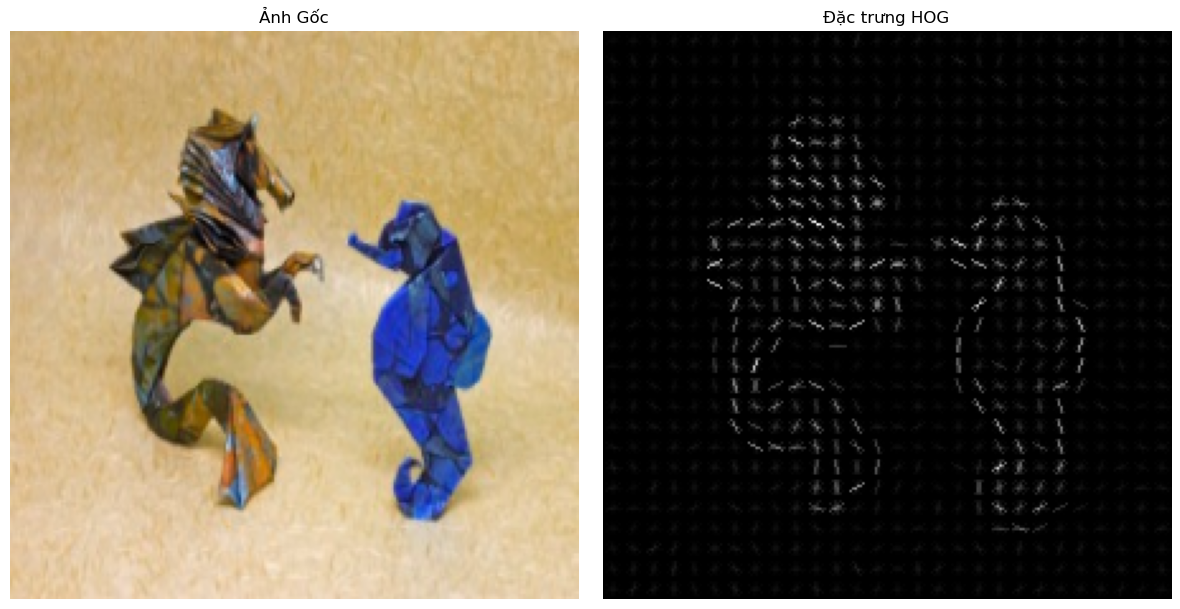

In [17]:
if 'sample_image' in locals():
    gray_sample = cv2.cvtColor(sample_image, cv2.COLOR_BGR2GRAY)
    
    # Trích xuất HOG và ảnh HOG để trực quan
    _, hog_image = hog(gray_sample, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), visualize=True, block_norm='L2-Hys')

    # Trực quan hóa
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

    ax1.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
    ax1.set_title('Ảnh Gốc')
    ax1.axis('off')

    ax2.imshow(hog_image, cmap='gray')
    ax2.set_title('Đặc trưng HOG')
    ax2.axis('off')

    plt.tight_layout()
    plt.show()

#### 4. Trích xuất LBP Features

In [ ]:
# Trích xuất cho cả 3 tập
X_train_lbp = apply_feature_extraction(X_train, extract_lbp_features, "LBP (Train)")
X_val_lbp   = apply_feature_extraction(X_val, extract_lbp_features, "LBP (Val)")
X_test_lbp  = apply_feature_extraction(X_test, extract_lbp_features, "LBP (Test)")

# In thông tin
if X_train_lbp is not None:
    print(f"\nShape của đặc trưng LBP (Train): {X_train_lbp.shape}")
    # print(f"Mẫu đặc trưng đầu tiên:\n{X_train_lbp[0][:10]}...")

Extracting LBP (Train):   0%|          | 0/8226 [00:00<?, ?it/s]

Extracting LBP (Val):   0%|          | 0/2742 [00:00<?, ?it/s]

Extracting LBP (Test):   0%|          | 0/2743 [00:00<?, ?it/s]


Shape của đặc trưng LBP (Train): (8226, 26)
Mẫu đặc trưng đầu tiên:
[0.04272959 0.03433913 0.01325335 0.00717474 0.00560029 0.00488281
 0.00504225 0.00542092 0.00593909 0.00593909]...


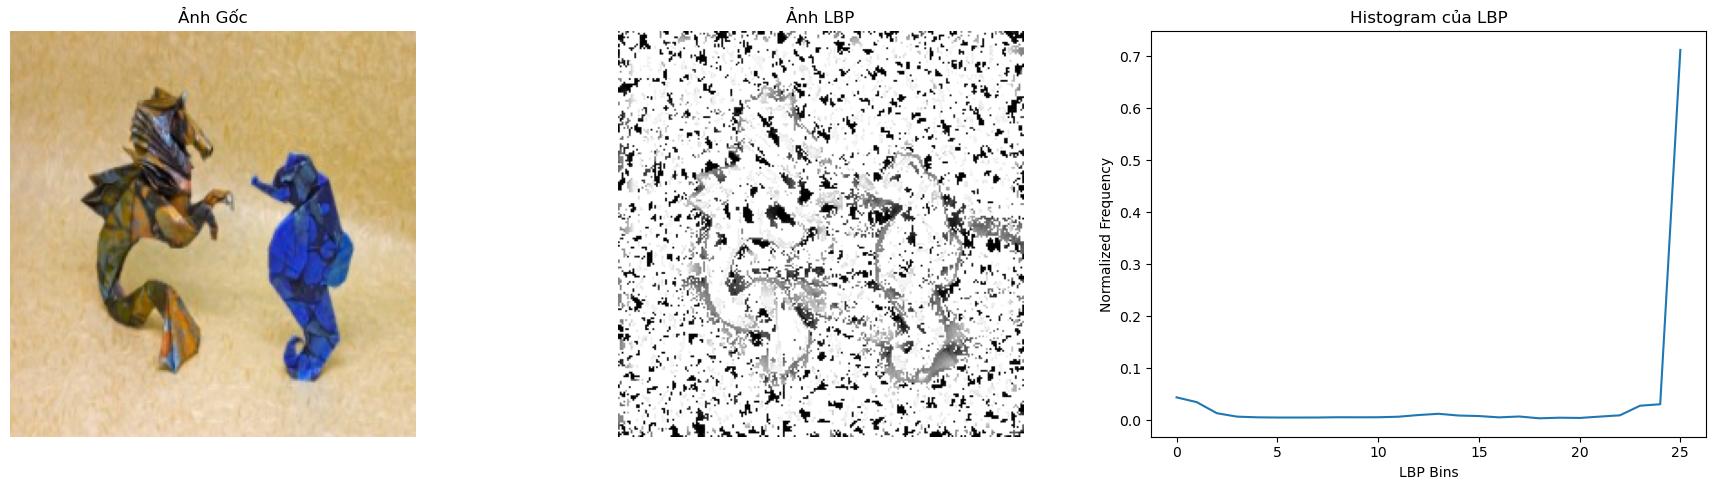

In [18]:
if 'sample_image' in locals():
    P = 24
    R = 8
    gray_sample = cv2.cvtColor(sample_image, cv2.COLOR_BGR2GRAY)
    
    # Tính LBP image
    lbp_image = local_binary_pattern(gray_sample, P, R, method="uniform")
    
    # Tính histogram của LBP
    lbp_hist = extract_lbp_features(sample_image, P=P, R=R)

    # Trực quan hóa
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    axes[0].imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Ảnh Gốc")
    axes[0].axis('off')

    axes[1].imshow(lbp_image, cmap='gray')
    axes[1].set_title("Ảnh LBP")
    axes[1].axis('off')

    axes[2].plot(lbp_hist)
    axes[2].set_title("Histogram của LBP")
    axes[2].set_xlabel("LBP Bins")
    axes[2].set_ylabel("Normalized Frequency")
    
    plt.tight_layout()
    plt.show()

### Kết hợp và lưu trữ đặc trưng

In [ ]:
def combine_and_save_features(output_dir, filename, y_data, **features):
    # Kiểm tra xem có dữ liệu để xử lý không
    if y_data is None or not all(v is not None for v in features.values()):
        print(f"Bỏ qua lưu file '{filename}' do thiếu dữ liệu.")
        return

    # Lấy danh sách các mảng đặc trưng cần kết hợp
    feature_arrays = [features[key] for key in sorted(features.keys())]

    # Kết hợp đặc trưng
    X_combined = np.hstack(feature_arrays)

    # In thông tin shape
    print(f"Đang xử lý file: {filename}")
    for name, data in features.items():
        print(f"  - Shape {name}: {data.shape}")
    print(f"  - Shape Combined: {X_combined.shape}")

    # Tạo payload để lưu
    save_payload = {**features, 'X_combined': X_combined, 'y': y_data}

    # Lưu file
    output_path = output_dir / filename
    np.savez(output_path, **save_payload)
    print(f"Đã lưu đặc trưng vào: '{output_path}'\n")

# Xử lý và lưu cho tập TRAIN
combine_and_save_features(
    PROCESSED_DIR, 'train_features.npz', y_train,
    X_hist=X_train_hist, X_sharp=X_train_sharp, X_hog=X_train_hog, X_lbp=X_train_lbp
)

# Xử lý và lưu cho tập VALIDATION
combine_and_save_features(
    PROCESSED_DIR, 'val_features.npz', y_val,
    X_hist=X_val_hist, X_sharp=X_val_sharp, X_hog=X_val_hog, X_lbp=X_val_lbp
)

# Xử lý và lưu cho tập TEST
combine_and_save_features(
    PROCESSED_DIR, 'test_features.npz', y_test,
    X_hist=X_test_hist, X_sharp=X_test_sharp, X_hog=X_test_hog, X_lbp=X_test_lbp
)

print("Hoàn tất toàn bộ quá trình trích xuất và lưu trữ!")

Đang xử lý file: train_features.npz
  - Shape X_hist: (8226, 512)
  - Shape X_sharp: (8226, 256)
  - Shape X_hog: (8226, 26244)
  - Shape X_lbp: (8226, 26)
  - Shape Combined: (8226, 27038)
==> Đã lưu đặc trưng vào: '/Users/CONG HAU/UIT-CS-PROJECTS/CS231 - Introduction to Computer Vision/data/03_processed/train_features.npz'

Đang xử lý file: val_features.npz
  - Shape X_hist: (2742, 512)
  - Shape X_sharp: (2742, 256)
  - Shape X_hog: (2742, 26244)
  - Shape X_lbp: (2742, 26)
  - Shape Combined: (2742, 27038)
==> Đã lưu đặc trưng vào: '/Users/CONG HAU/UIT-CS-PROJECTS/CS231 - Introduction to Computer Vision/data/03_processed/val_features.npz'

Đang xử lý file: test_features.npz
  - Shape X_hist: (2743, 512)
  - Shape X_sharp: (2743, 256)
  - Shape X_hog: (2743, 26244)
  - Shape X_lbp: (2743, 26)
  - Shape Combined: (2743, 27038)
==> Đã lưu đặc trưng vào: '/Users/CONG HAU/UIT-CS-PROJECTS/CS231 - Introduction to Computer Vision/data/03_processed/test_features.npz'

Hoàn tất toàn bộ quá t